# IBM Q Experience の使い方

　IBM Q Experienceは2016年5月24日にIBM社が世界で初めてクラウド上に公開した量子コンピュータである。[[1]](https://quantumexperience.ng.bluemix.net/qx/experience)
 この章ではIBM Q Experienceの使い方及びIBM社が開発している量子計算用PythonフレームワークQiskitの使い方を学ぶ。

## アカウント登録
　1.まず、IBM Q ExperienceのWebページ[[1]](https://quantumexperience.ng.bluemix.net/qx/experience) の右上のSign Inボタンをクリックしてアカウントを作る。
 
  2.メールアドレスとパスワードもしくは外部サービスのアカウントが要求されるが、Sign Inボタン下のSign Upをクリックする。
  
  3.必要事項を記入し、Sign Upボタンをクリックする。
  
  4.登録したメールアドレスにメールが送られるので、そのメール内のリンクをクリックする。すると別ウィンドウで登録完了の画面が出るので、次からはログイン可能になる。

## APIの取得
 これでIBM Q Experienceに登録できたので、次はIBM Q Experienceの実機(本物の量子コンピュータ)のアクセスに必要なIBM Q Experience APIの取得の仕方を学ぶ。
 
 1.ログイン後にWelcome to Experience!のポップアップが出るので右上の×印をクリックして閉じる。
 
 2.画面右上のアイコン → "My Account"をクリックし、登録したアカウント情報を見る。
 
 3.画面右上に"Account","Community", "Advanced"のうち"Advanced"をクリックする。
 
 4."API Token"の欄が"undefined"になっているので、"Regenerate"ボタンをクリックしてAPIを生成する。
 
 隣の"Copy this token"ボタンを押すとAPIをクリップボードに貼り付けられる。

# Qiskit の使い方

## インストールの方法

0.QiskitはPython3.5以上でしか作動しないので、もしお持ちでない方はPythonのサイト[[3]](https://www.python.org/downloads/)からダウンロードする。
 
1.PC内のコマンドライン(Windowsのコマンドプロンプト、Macのターミナル)に`pip install qiskit`と入力して実行する。Jupyter Notebookをお使いの方は、セル内に`!pip install qiskit`と入力するとAnaconda環境で使えるようになる。


## Qiskitの書き方
　QiskitはPythonフレームワークなので書く時の文法はPythonと同じである。その前に実機の使用に必要な情報を`Qconfig.py`にまとめて実行するファイルと同じディレクトリに保存する必要がある。`Qconfig.py`の中身は以下の通りである。

In [1]:
#'MY_API_TOKEN'にAPIをペーストする。
APItoken = 'MY_API_TOKEN'

config = {
    'url': 'https://quantumexperience.ng.bluemix.net/api',
    #IBM Q Networkユーザーは以下の情報も入力する。IBM Q Networkとは、IBMが量子コンピューティングの研究開発のために特別に結んだ協定で、
    #提携先に所属していれば20量子ビットの量子コンピュータが使える。ちなみに、アジアでは唯一慶應義塾大学(ibmq_20_tokyo)が選ばれている。
    #'hub': 'MY_HUB',
    #'group': 'MY_GROUP',
    #'project': 'MY_PROJECT'
}

if 'APItoken' not in locals():
  raise Exception("Please set up your access token. See Qconfig.py.")

次にここではBell状態のうち$|\Psi^{+}\rangle$ペアの生成のプログラムを例に学んでいく。ちなみに、$|\Psi^{+}\rangle$ペアは$\frac{|00\rangle + |11\rangle}{\sqrt{2}}$ で表される。

In [1]:
#必要なモジュールのインポート
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import numpy as np
import Qconfig

In [7]:
#自分のアカウントを保存する。これ以降はIBMQ.load_account()を入力すればいい。
IBMQ.save_account(Qconfig.APItoken)

#自分のアカウントで使用できるバックエンドを見る
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

IBM Q Experienceの一般ユーザーは4量子ビットの実機'ibmqx4'、16量子ビットの実機'ibmqx16'、
そして32量子ビットの量子シミュレータ'ibmq_qasm_simulator'が使えることが分かった。以下のコマンドを打つと1番ジョブが投げやすい実機が分かる。

In [6]:
from qiskit.providers.ibmq import least_busy
large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 3 \
                                                    and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


ibmq_16_melbourneが1番忙しくないことが分かったので、今回はそれを実機として使う。次にシミュレータ、実機の順で結果を見ていく。

{'00': 1952, '11': 2144}


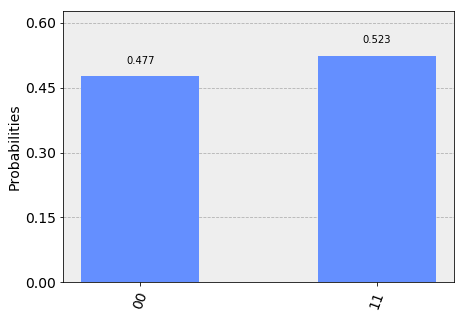

In [4]:
#量子レジスタqを生成する。
q = QuantumRegister(2)

#古典レジスタcを生成する
c = ClassicalRegister(2)

#量子レジスタqと古典レジスタc間で量子回路を生成する。
qc = QuantumCircuit(q, c)

#1番目の量子ビットにHゲートをかける。
qc.h(q[0])

#1-2番目の量子ビットにCNOTゲートをかける。(1番目の量子ビットが制御量子ビット、2番目の量子ビットがコントロール量子ビット)
qc.cx(q[0],q[1])

#1番目の量子ビットの測定値を1番目の古典ビットに、2番目の量子ビットの測定値を2番目の古典ビットに渡す。
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])


backends = ['qasm_simulator','ibmq_16_melbourne']

#シミュレータを使う時は下をコメントアウトする。
backend_sim = Aer.get_backend(backends[0])

#実機を使う時は下の行をコメントアウトする。
#backend_sim = IBMQ.get_backend(backends[1])

#量子回路qcを指定したバックエンド(backend_sim)で4096回実行する。
result = execute(qc, backend_sim, shots=4096).result()

#結果を出力する。
print(result.get_counts(qc))

#結果のヒストグラムを描画する。
plot_histogram(result.get_counts(qc))

式の通り$|00\rangle$、$|11\rangle$が得られる確率は共に50%に近いことが分かる。次に実機の結果を見てみよう。但し、実機での実験は結果を得るのに非常に時間がかかるので注意が必要だ。

{'01': 189, '10': 199, '00': 2181, '11': 1527}


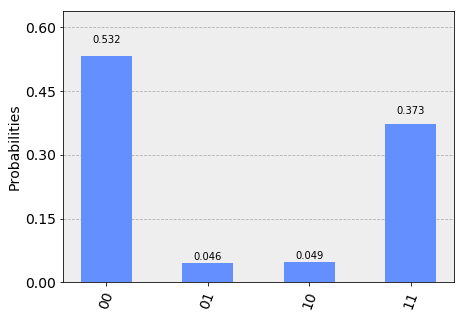

In [7]:
#量子レジスタqを生成する。
q = QuantumRegister(2)

#古典レジスタcを生成する
c = ClassicalRegister(2)

#量子レジスタqと古典レジスタc間で量子回路を生成する。
qc = QuantumCircuit(q, c)

#1番目の量子ビットにHゲートをかける。
qc.h(q[0])

#1-2番目の量子ビットにCNOTゲートをかける。(1番目の量子ビットが制御量子ビット、2番目の量子ビットがコントロール量子ビット)
qc.cx(q[0],q[1])

#1番目の量子ビットの測定値を1番目の古典ビットに、2番目の量子ビットの測定値を2番目の古典ビットに渡す。
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])


backends = ['qasm_simulator','ibmq_16_melbourne']

#シミュレータを使う時は下をコメントアウトする。
#backend_sim = Aer.get_backend(backends[0])

#実機を使う時は下の行をコメントアウトする。
backend_sim = IBMQ.get_backend(backends[1])

#量子回路qcを指定したバックエンド(backend_sim)で4096回実行する。
result = execute(qc, backend_sim, shots=4096).result()

#結果を出力する。
print(result.get_counts(qc))

#結果のヒストグラムを描画する。
plot_histogram(result.get_counts(qc))

実機による結果を見てみると、理論上では得られない$|01\rangle$と$|10\rangle$が得られていることが分かる。これは演算過程で生じたエラーによるものである。今の量子コンピュータがNISQ(中規模でノイズの発生を許す量子コンピュータ)と呼ばれている所以である。

## Quantum Volumeとは
 超電導量子ビットを採用しているIBMQとイオントラップ式の他社のコンピュータの性能を比較しようとしてもは特徴が違いすぎるので一概に比較できない。そこで出てくるのがquantum volumeである。
 
 quantum volumeとは、その量子コンピュータが特定のアルゴリズムをどれくらい効率的に実装できるかを表す指標である。Quantum Volumeは一定の量子ビット数とゲートの深さ(同時にゲートをかける回数)を元に、複数のランダムなゲート群(1量子ビットとCNOTゲート)を掛けることで求められる。
 
 この作業をベンチマーキングと呼び、実際にquantum volumeを測定する際は100回単位で行われる。

## Quantum Volumeの求め方　

 ここではquantum volumeの求め方を述べる。なお、quantum volumeを計る実機の量子ビット数をn個とする。

1. 量子ビット数を$m$個、深さ(同時にゲートを掛けるタイミングの数)$d$の量子回路$U$をランダムに生成する。　


2. まず、$P_U(x) = {|\langle x |U|0\rangle|}^{2}(x=\{0,1\}^{m})$,その確率分布の中央値を$P_{med}$とする。そして$H_U = 　\{x |\in \{0,1\}^{m} P_U(x) > P_{med} \}$ を満たす集合をheavy outputsとする。　


3. 深さ1のゲート$U$で得た確率分布$q_U$のうち、heavy outputsを得た確率を$h_U = \sum_{x \in {H_U}} q_U(x)$求める。それから、深さdのゲートUをかけた時のheavy outputsが出た確率$h_d = \int_{U}^{} h_U dU$を求める。　　


4. $h_1,h_2,h_3...h_{d}  > \frac{2}{3},\,\,h_{d+1} \leq \frac{2}{3}$を満たす数字$h_d$を見つける。　


5. $\newcommand{\argmax}{\mathop{\rm arg~max}\limits}
log_{2} V_Q = \argmax_{m} min(m,h_{d})$ を満たす値$V_Q$こそがquantum volumeである。つまり、$(m,h_d)$のうち小さい方の数字を試行ごとに算出して、その中で1番大きい数字を$N$とすると、$2^{N}$がその実機のquantum volumeである。

例えば、以下のコード[7]を実行すれば1回分のベンチマーキングが体験できるが、出力が煩雑なので実行しなくて良い。ちなみに、これは量子ビット数5、深さが5のケースである。

In [ ]:
import math
import argparse
from numpy import random
from scipy import linalg
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.mapper import two_qubit_kak
from qiskit import execute,Aer, compile

#ランダムな行列を生成する
def random_SU(n):
    """Return an n x n Haar distributed unitary matrix,
    using QR-decomposition on a random n x n.
    """
    X = (random.randn(n, n) + 1j * random.randn(n, n))
    Q, R = linalg.qr(X)           # Q is a unitary matrix
    Q /= pow(linalg.det(Q), 1/n)  # make Q a special unitary
    return Q

#上の関数の出力を元にランダムな量子ゲートを生成する。
def build_model_circuits(n, depth, num_circ=1):
    """Create a quantum program containing model circuits.
    The model circuits consist of layers of Haar random
    elements of SU(4) applied between corresponding pairs
    of qubits in a random bipartition.
    Args:
        n (int): number of qubits
        depth (int): ideal depth of each model circuit (over SU(4))
        num_circ (int): number of model circuits to construct
    Returns:
        list(QuantumCircuit): list of quantum volume circuits
    """
    # Create quantum/classical registers of size n
    q = QuantumRegister(n)
    c = ClassicalRegister(n)
    # For each sample number, build the model circuits
    circuits = []
    for i in range(num_circ):
        # Initialize empty circuit
        circuit = QuantumCircuit(q, c)
        # For each layer
        for j in range(depth):
            # Generate uniformly random permutation Pj of [0...n-1]
            perm = random.permutation(n)
            # For each consecutive pair in Pj, generate Haar random SU(4)
            # Decompose each SU(4) into CNOT + SU(2) and add to Ci
            for k in range(math.floor(n/2)):
                qubits = [int(perm[2*k]), int(perm[2*k+1])]
                SU = random_SU(4)
                decomposed_SU = two_qubit_kak(SU)
                for gate in decomposed_SU:
                    i0 = qubits[gate["args"][0]]
                    if gate["name"] == "cx":
                        i1 = qubits[gate["args"][1]]
                        circuit.cx(q[i0], q[i1])
                    elif gate["name"] == "u1":
                        circuit.u1(gate["params"][2], q[i0])
                    elif gate["name"] == "u2":
                        circuit.u2(gate["params"][1], gate["params"][2], q[i0])
                    elif gate["name"] == "u3":
                        circuit.u3(gate["params"][0], gate["params"][1],
                                   gate["params"][2], q[i0])
                    elif gate["name"] == "id":
                        pass
        # Barrier before measurement to prevent reordering, then measure
        circuit.barrier(q)
        circuit.measure(q, c)
        # Save sample circuit
        circuits.append(circuit)
    return circuits


#量子ビット5、深さ(ゲート数)5の場合において、ランダムな回路を生成する。
circuits = build_model_circuits(n=5, depth=5,num_circ=1   
                                
for i in range(1):
    qasm_circuit = circuits[i].qasm()
    
if __name__ == "__main__":
    
    
#OpenQASMを使ったジョブを投げるためのモジュールをインポートする
    from IBMQuantumExperience import IBMQuantumExperience

    #自身のAPIを読み込む
    api = IBMQuantumExperience(Qconfig.APItoken)
    
    #OpenQASMでジョブを投げる。これはsimulatorで実行するときのコマンドである。
    #実機に実行する時はapi.run_job(qasmの変数, "実機の名前",shots=試行の回数,\
                                            #max_credits=クレジットの数、
                                            #ジョブの実行に必要なクレジットがこの値を超えると実行されなくなる)
    result = api.run_experiment(qasm_circuit, shots=1024, name=None, timeout=60)
    
    #結果を表示する
    print(result.values())

 最後に、Quantum Volumeを向上させる方法をいくつか紹介する。ちなみに以下の画像は全て[[6]](https://arxiv.org/pdf/1811.12926.pdf)の論文に掲載されていたものである。　

 まずは、量子ビット間の連結度の向上である。下の表は3種類の量子ビットの連結の構造において一定のQuantum volumeを達成するために必要な2量子ビットのエラー率である。Square GridとLoopの各値はあまり差がないが、All-to-All,つまり任意の量子ビットから他の任意の量子ビットに2量子ビットが掛けられれば、2量子ビットのエラー率は他の構造に比べて高くてもいいことが分かる。
![screen shot 2019-02-16 at 12 45 04 pm](https://user-images.githubusercontent.com/45162150/52894171-bb88f700-31e8-11e9-9d88-e0267167757d.png)

 次に、エラー率の低下である。下の表はSquare Gridにおける測定のエラー率を0%,1%,5%とした時に一定のQuantum Volumeを達成するために必要な2量子ビットゲートのエラー率である。高いQuantum volumeを得ようとすればするほどゲートのエラー率を下げる必要があるのが分かる。
![screen shot 2019-02-16 at 12 23 46 pm](https://user-images.githubusercontent.com/45162150/52894068-34874f00-31e7-11e9-863e-1bec4d6334fd.png)

参考文献 

[1]https://quantumexperience.ng.bluemix.net/qx/experience [online] (参照日時 2019-02-13)

[2]沼田祈史(2017) 「IBM Q Computingで計算してみよう」[online] https://www.ibm.com/developerworks/jp/cloud/library/cl-quantum-computing/index.html (参照日時 2019-02-13)

[3] "Python Download | Python.org" [online] https://www.python.org/downloads/ (参照日時 2019-02-13)

[4]「qiskit-terra – TerraはQiskitの基礎を提供します。 これは、ユーザが量子回路を簡単に書き込むことを可能にし、実際のハードウェアの制約を.」[online] https://githubja.com/qiskit/qiskit-terra(参照日時 2019-02-13)

[5]"Qiskit Terra Documentation - Qiskit Terra 0.7.0 documentation" [online] https://qiskit.org/documentation/ (参照日時 2019-02-13) 

[6] Andrew W Cross, Lev S.Bishop, Sarah Sheldon, Paul D. Notion,Jay M Gambetta, *Validating quantum computers using randamized model circuits* arXiv:1811.12926,2018 

[7] https://github.com/Qiskit/openqasm/blob/master/benchmarks/quantum_volume/quantum_volume.py (参照日時 2019-02-16) 